# Loan Approval Prediction – Machine Learning Project

## 1. Import Libraries

In [84]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

## 2. Load Dataset

In [85]:
df = pd.read_csv("/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv")
df.columns = df.columns.str.strip()

print("Shape:", df.shape)
df.head()

Shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## 3. Data Overview and Missing Values

In [86]:
print(df.info())
print("\nMissing values per column:")
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB
None

Missing values per colum

## 4. Drop Unnecessary Columns

In [87]:
df = df.drop(columns=["loan_id"])

## 5. Handling Missing Values and Defining Feature Types

In [88]:
numeric_features = [
    "income_annum", "loan_amount", "loan_term", "cibil_score",
    "residential_assets_value", "commercial_assets_value",
    "luxury_assets_value", "bank_asset_value"
]

categorical_features = [
    "no_of_dependents", "education", "self_employed"
]

for col in numeric_features:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_features + ["loan_status"]:
    df[col] = df[col].fillna(df[col].mode()[0])

print("after treatment missing:")
print(df.isna().sum())

بعد معالجة الـ missing:
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64


## 6. Encode Target Variable and Define Features/Labels

In [89]:
df["loan_status"] = df["loan_status"].astype(str).str.strip().str.title()

df = df[df["loan_status"].isin(["Approved", "Rejected"])]

df["loan_status"] = df["loan_status"].map({"Approved": 1, "Rejected": 0})

print("Unique classes in target:", df["loan_status"].unique())
print(df["loan_status"].value_counts())


X = df.drop(columns=["loan_status"]) 
y = df["loan_status"]    

Unique classes in target: [1 0]
loan_status
1    2656
0    1613
Name: count, dtype: int64


## 7. Preprocessing Pipeline (Scaling and One-Hot Encoding)

In [90]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),

        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"),
         categorical_features)
   
    ]
)

## 8. Train/Test Split

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,       
    random_state=42,
    stratify=y           
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (2988, 11) Test shape: (1281, 11)
Train shape: (2988, 11) Test shape: (1281, 11)


## 9. Evaluation Metrics Function

In [92]:
def print_classification_metrics(y_true, y_pred, title="Model"):
    print(f"\n===== {title} =====")
    print("Accuracy :", accuracy_score(y_true, y_pred))

    print("Precision:", precision_score(y_true, y_pred, average='weighted', zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, average='weighted', zero_division=0))
    print("F1 Score :", f1_score(y_true, y_pred, average='weighted', zero_division=0))

## 10. Baseline Model 1 – Logistic Regression


===== Logistic Regression =====
Accuracy : 0.9195940671350508
Precision: 0.9194179962573535
Recall   : 0.9195940671350508
F1 Score : 0.9194770036649528


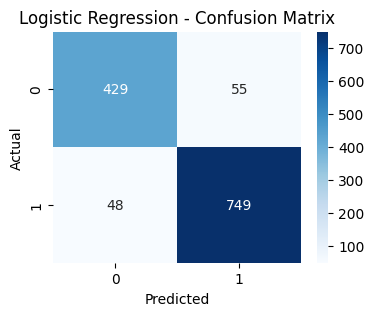

In [93]:
log_reg_model = Pipeline(steps=[
    ("preprocess", preprocessor),                
    ("model", LogisticRegression(max_iter=500))  
])

log_reg_model.fit(X_train, y_train)

y_pred_lr = log_reg_model.predict(X_test)

print_classification_metrics(y_test, y_pred_lr, "Logistic Regression")

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(4,3))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


tree_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(
        criterion="gini",     
        max_depth=5,
        min_samples_split=10,
        random_state=42
    ))
])

## 11. Logistic Regression – Hyperparameter Tuning (GridSearchCV)

In [94]:
from sklearn.model_selection import GridSearchCV

log_reg_params = {
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"],   
}

log_reg_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

grid_lr = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=log_reg_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print("Best Parameters:", grid_lr.best_params_)
print("Best CV Score :", grid_lr.best_score_)

y_pred_lr_grid = grid_lr.predict(X_test)

print_classification_metrics(y_test, y_pred_lr_grid,
                             "Logistic Regression (GridSearch)")

Best Parameters: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV Score : 0.9163369803308627

===== Logistic Regression (GridSearch) =====
Accuracy : 0.9195940671350508
Precision: 0.9193647327534344
Recall   : 0.9195940671350508
F1 Score : 0.91940749842199


## 12. Baseline Model 2 – Decision Tree


===== Decision Tree =====
Accuracy : 0.9734582357533177
Precision: 0.974041700656905
Recall   : 0.9734582357533177
F1 Score : 0.973548932389569


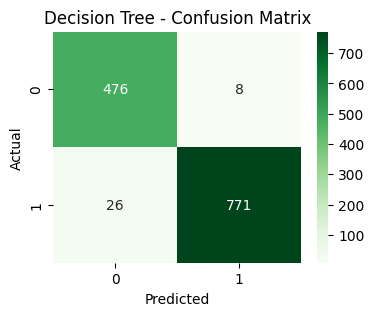

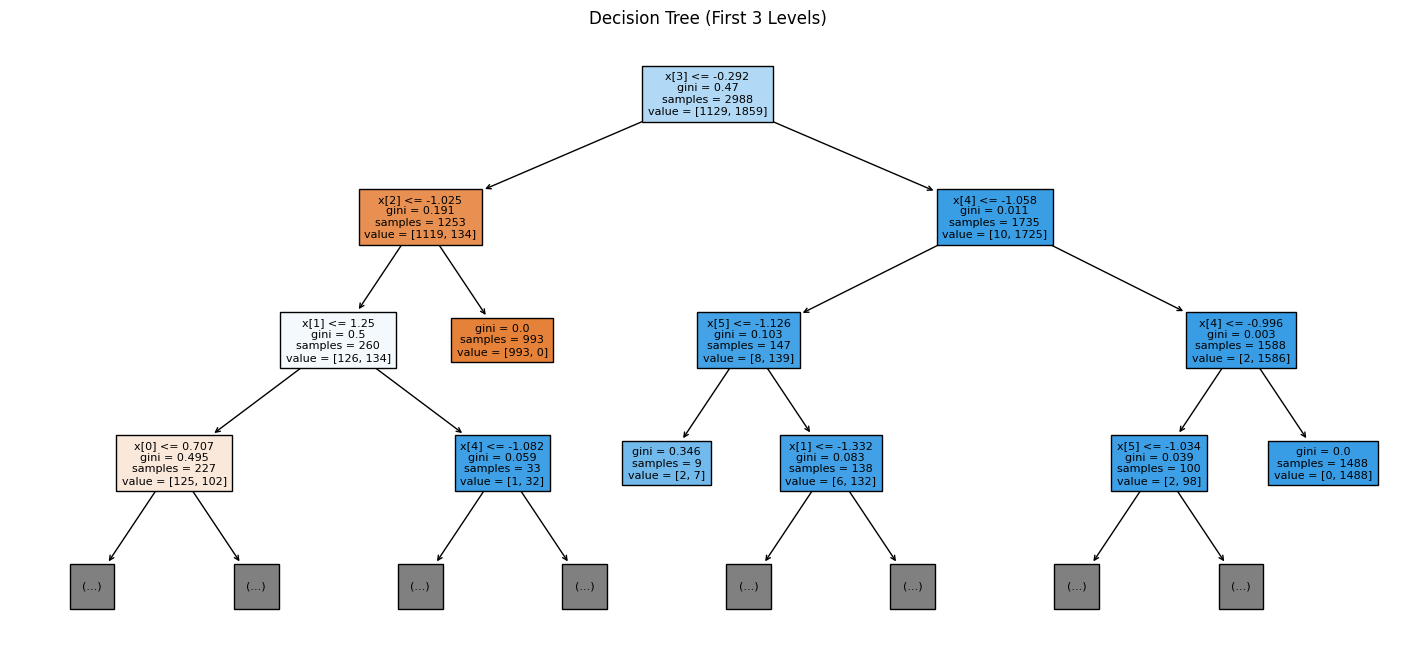

In [95]:
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)

print_classification_metrics(y_test, y_pred_tree, "Decision Tree")

cm_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(4,3))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Greens")
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


final_tree = tree_model.named_steps["model"]

plt.figure(figsize=(18, 8))
plot_tree(final_tree,
          filled=True,
          max_depth=3,   
          fontsize=8)
plt.title("Decision Tree (First 3 Levels)")
plt.show()

## 13. Decision Tree – Hyperparameter Tuning (GridSearchCV)

In [96]:
tree_params = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [3, 5, 7, 10, None],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10]
}

tree_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

grid_tree = GridSearchCV(
    estimator=tree_pipeline,
    param_grid=tree_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)

print("Best Parameters:", grid_tree.best_params_)
print("Best CV Score :", grid_tree.best_score_)

y_pred_tree_grid = grid_tree.predict(X_test)

print_classification_metrics(y_test, y_pred_tree_grid, "Decision Tree (GridSearch)")

Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
Best CV Score : 0.9772429595020812

===== Decision Tree (GridSearch) =====
Accuracy : 0.9843871975019516
Precision: 0.9844170882893429
Recall   : 0.9843871975019516
F1 Score : 0.9843611274353585


## 14. Baseline Model 3 – Random Forest

In [97]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print_classification_metrics(y_test, y_pred_rf, "Random Forest")


===== Random Forest =====
Accuracy : 0.9804839968774395
Precision: 0.9804931528078275
Recall   : 0.9804839968774395
F1 Score : 0.9804879415042311


## 15. Random Forest – Hyperparameter Tuning (GridSearchCV)

In [98]:
rf_params = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [5, 10, 15, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"] 

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

grid_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best Parameters:", grid_rf.best_params_)
print("Best CV Score :", grid_rf.best_score_)

y_pred_rf_grid = grid_rf.predict(X_test)

print_classification_metrics(y_test, y_pred_rf_grid,
                             "Random Forest (GridSearch)")

Best Parameters: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Best CV Score : 0.9775774076626164

===== Random Forest (GridSearch) =====
Accuracy : 0.9812646370023419
Precision: 0.9812847970229601
Recall   : 0.9812646370023419
F1 Score : 0.981272183365462


## 16. Baseline Model 4 – Gradient Boosting

In [99]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print_classification_metrics(y_test, y_pred_gb, "Gradient Boosting")



===== Gradient Boosting =====
Accuracy : 0.9867291178766588
Precision: 0.9867249922314527
Recall   : 0.9867291178766588
F1 Score : 0.9867264161445871


## 17. Baseline Model 5 – AdaBoost

In [100]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", AdaBoostClassifier(
        n_estimators=150,
        learning_rate=0.05,
        random_state=42
    ))
])

ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)

print_classification_metrics(y_test, y_pred_ada, "AdaBoost Baseline")



===== AdaBoost Baseline =====
Accuracy : 0.9578454332552693
Precision: 0.9612874687100778
Recall   : 0.9578454332552693
F1 Score : 0.958186805764076


## 18. AdaBoost – Hyperparameter Tuning (GridSearchCV)

In [101]:
ada_params = {
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.01, 0.05, 0.1, 1.0],
}

ada_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", AdaBoostClassifier(random_state=42))
])

grid_ada = GridSearchCV(
    estimator=ada_pipeline,
    param_grid=ada_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_ada.fit(X_train, y_train)

print("Best Parameters:", grid_ada.best_params_)
print("Best CV Score :", grid_ada.best_score_)

y_pred_ada_grid = grid_ada.predict(X_test)

print_classification_metrics(y_test, y_pred_ada_grid, "AdaBoost (GridSearch)")

Best Parameters: {'model__learning_rate': 1.0, 'model__n_estimators': 200}
Best CV Score : 0.9779135364671742

===== AdaBoost (GridSearch) =====
Accuracy : 0.9797033567525371
Precision: 0.9797970843225271
Recall   : 0.9797033567525371
F1 Score : 0.9797275282963422


## 19. Baseline Model 6 – SVM

In [102]:
from sklearn.svm import SVC

svm_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", SVC(kernel="rbf"))
])

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print_classification_metrics(y_test, y_pred_svm, "SVM Baseline")


===== SVM Baseline =====
Accuracy : 0.9453551912568307
Precision: 0.9456897128727881
Recall   : 0.9453551912568307
F1 Score : 0.9454620715180908


## 20. Baseline Model 7 – XGBoost

In [103]:
from xgboost import XGBClassifier

xgb_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss"
    ))
])

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print_classification_metrics(y_test, y_pred_xgb, "XGBoost")


===== XGBoost =====
Accuracy : 0.9843871975019516
Precision: 0.9843871975019516
Recall   : 0.9843871975019516
F1 Score : 0.9843871975019516


## 21. Additional Confusion Matrix Visualizations

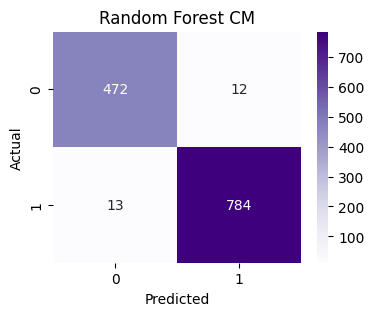

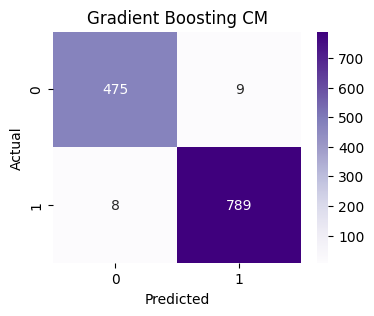

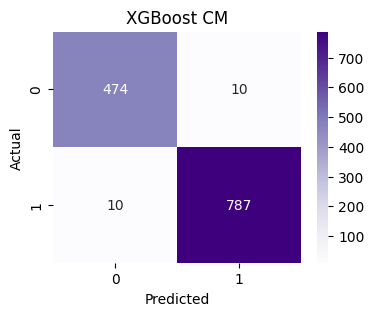

In [104]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_cm(y_test, y_pred_rf, "Random Forest CM")
plot_cm(y_test, y_pred_gb, "Gradient Boosting CM")
plot_cm(y_test, y_pred_xgb, "XGBoost CM")

## 22. Simple Accuracy Comparison (Top Models)

In [105]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_tree),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gb),
        accuracy_score(y_test, y_pred_xgb),
    ]
})

results.sort_values(by="Accuracy", ascending=False)


,Model,Accuracy
3,Gradient Boosting,0.986729
4,XGBoost,0.984387
2,Random Forest,0.980484
1,Decision Tree,0.973458
0,Logistic Regression,0.919594


## 23. Final Comparison Table (All Models – Train/Test/Precision/Recall/F1)

In [106]:
def get_scores(model, X_train, X_test, y_train, y_test):
    """Return a dictionary of train/test metrics for comparison table."""
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    return {
        "Train Accuracy": accuracy_score(y_train, y_pred_train),
        "Test Accuracy": accuracy_score(y_test, y_pred_test),
        "Precision": precision_score(y_test, y_pred_test, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_pred_test, average="weighted", zero_division=0),
        "F1 Score": f1_score(y_test, y_pred_test, average="weighted", zero_division=0)
    }

results_dict = {
    "Logistic Regression (Baseline)": get_scores(log_reg_model, X_train, X_test, y_train, y_test),
    "Decision Tree (Baseline)": get_scores(tree_model, X_train, X_test, y_train, y_test),
    "Random Forest (Baseline)": get_scores(rf_model, X_train, X_test, y_train, y_test),
    "Gradient Boosting": get_scores(gb_model, X_train, X_test, y_train, y_test),
    "XGBoost": get_scores(xgb_model, X_train, X_test, y_train, y_test),

    "Logistic Regression (Tuned)": get_scores(grid_lr, X_train, X_test, y_train, y_test),
    "Decision Tree (Tuned)": get_scores(grid_tree, X_train, X_test, y_train, y_test),
    "Random Forest (Tuned)": get_scores(grid_rf, X_train, X_test, y_train, y_test),
    "AdaBoost (Baseline)": get_scores(ada_model, X_train, X_test, y_train, y_test),
    "AdaBoost (Tuned)": get_scores(grid_ada, X_train, X_test, y_train, y_test)
}

comparison_df = pd.DataFrame(results_dict).T
comparison_df


,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
Logistic Regression (Baseline),0.915663,0.919594,0.919418,0.919594,0.919477
Decision Tree (Baseline),0.972892,0.973458,0.974042,0.973458,0.973549
Random Forest (Baseline),0.999665,0.980484,0.980493,0.980484,0.980488
Gradient Boosting,0.997992,0.986729,0.986725,0.986729,0.986726
XGBoost,1.000000,0.984387,0.984387,0.984387,0.984387
Logistic Regression (Tuned),0.917001,0.919594,0.919365,0.919594,0.919407
Decision Tree (Tuned),0.985944,0.984387,0.984417,0.984387,0.984361
Random Forest (Tuned),0.996988,0.981265,0.981285,0.981265,0.981272
AdaBoost (Baseline),0.951807,0.957845,0.961287,0.957845,0.958187
AdaBoost (Tuned),0.989290,0.979703,0.979797,0.979703,0.979728


## 24. Bar Plot of Test Accuracy for All Models

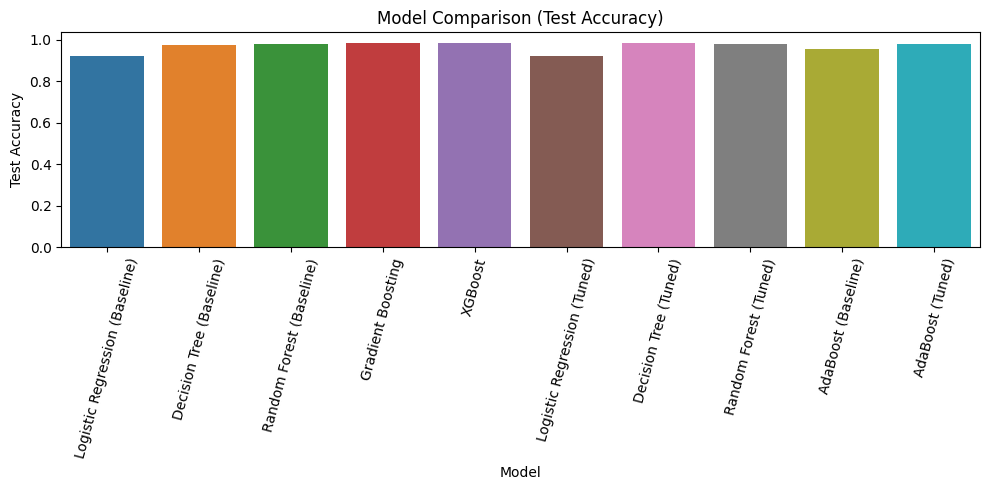

In [107]:
plt.figure(figsize=(10,5))
sns.barplot(
    x=comparison_df.index,
    y=comparison_df["Test Accuracy"]
)
plt.xticks(rotation=75)
plt.title("Model Comparison (Test Accuracy)")
plt.ylabel("Test Accuracy")
plt.xlabel("Model")
plt.tight_layout()
plt.show()